# MNIST (NN)
## Распознавание рукописных символов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

# модуль, где определены слои для нейронных сетей
import torch.nn as nn

In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(28, 28)


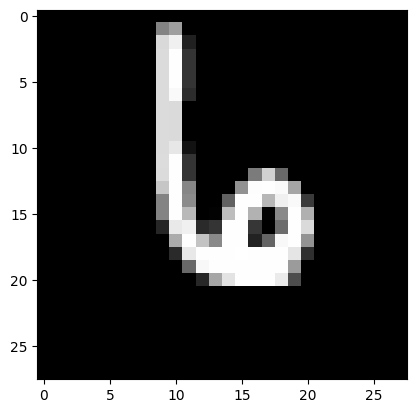

In [3]:
pixels = np.array(train.iloc[123][1:])
pixels = pixels.reshape((28, 28))
print(pixels.shape)
plt.imshow(pixels, cmap='gray')

In [4]:
from sklearn.model_selection import train_test_split

X_train = np.array(train.drop(columns=['label'])) / 255
y_train = np.array(train['label'])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train.shape: (33600, 784)
y_train.shape: (33600,)
X_test.shape: (8400, 784)


In [5]:
%%time

# определяем веса
x0 = np.random.normal(size=(784, 10)) / np.sqrt(784)
neurons = torch.tensor(x0, requires_grad=True) # requires_grad говорит о том что для тензора необходимо вычислить градиент 

# конвертируем датасет в читаймый торчом формат
X_tensor_train = torch.tensor(X_train)
y_tensor_train = torch.tensor(y_train)

# SGD
optimizer = torch.optim.SGD(params=[neurons], lr=1)
loss_history = []

iterCount = 100

for i in range(iterCount):
    predictions = X_tensor_train @ neurons
    
    # вычисляем loss
    loss = torch.nn.functional.cross_entropy(predictions, y_tensor_train) # функция активации уже включена
    
    # вычисляем градиент
    optimizer.zero_grad() # зануляем предыдущий градиент
    loss.backward() # вычисляем градиент
    
    # делаем шаг
    optimizer.step() # корректируем веса в соотвествии с градиентом
    
    # логируем loss
    loss_history.append(loss.data.numpy())

CPU times: user 16.9 s, sys: 433 ms, total: 17.4 s
Wall time: 11.3 s


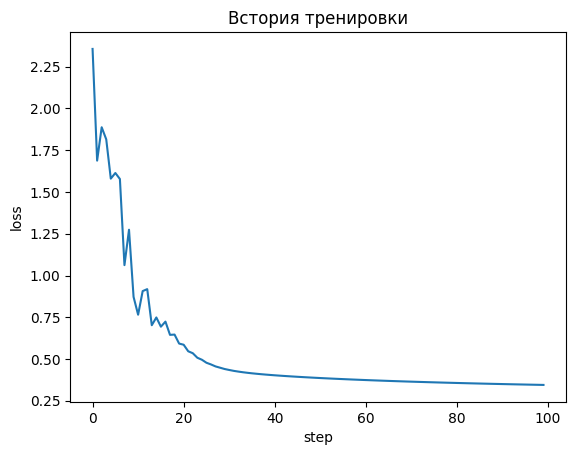

In [6]:
plt.title('Bстория тренировки')
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(loss_history)

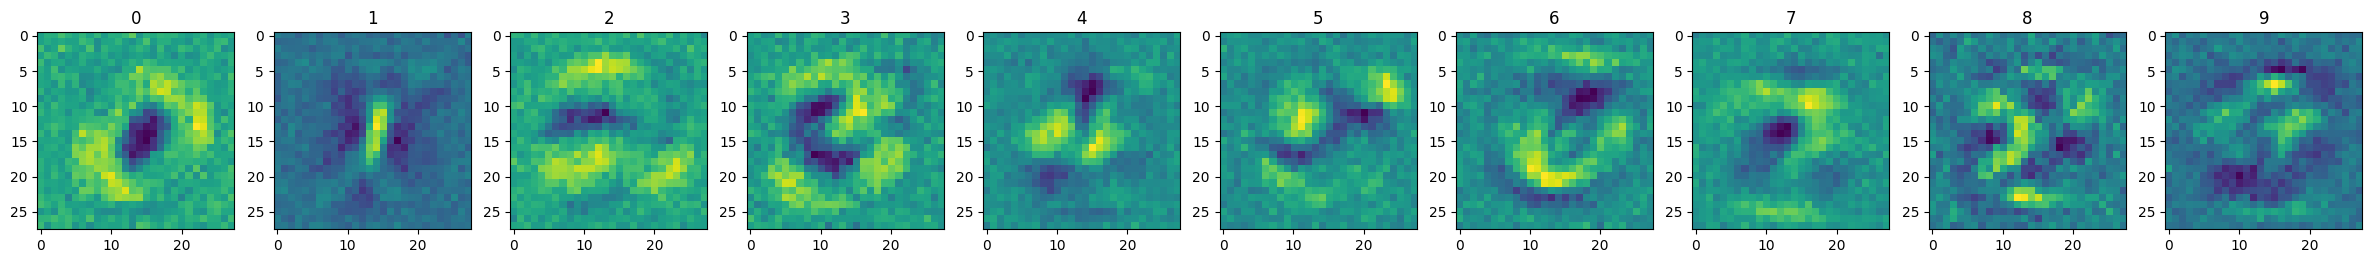

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(30, 30))

for i in range(10):
    axes[i].set_title(i)
    neuron_img = neurons[:, i].data.numpy().reshape(28, 28)
    axes[i].imshow(neuron_img)

In [8]:
from sklearn.metrics import f1_score

def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

digit_probabilities_train = sigmoid((X_tensor_train @ neurons).data.numpy())

predictions_train = np.argmax(digit_probabilities_train, axis=1)
f1_train = f1_score(y_train, predictions_train, average='macro')
print(f'Train f1: {f1_train}')

Train f1: 0.902264467860712


In [9]:
X_tensor_test = torch.tensor(X_test)
y_tensor_test = torch.tensor(y_test)

digit_probabilities_test = sigmoid((X_tensor_test @ neurons).data.numpy())

predictions_test = np.argmax(digit_probabilities_test, axis=1)
f1_test = f1_score(y_test, predictions_test, average='macro')
print(f'Test f1: {f1_test}')

Test f1: 0.9025984539205503


In [10]:
# модуль, где определены функции активации для слоев нейронных сетей
import torch.nn.functional as F

class FirstNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        super().__init__()
        
        # Здесь мы определяем обучаемые параметры модели
        # Первый слой весов
        # init_1 = np.random.normal(size=(784, n_hidden_neurons)) / np.sqrt(784) # гуглите "xavier initialization"
        # self.neurons_layer1 = torch.tensor(init_1, requires_grad=True) # веса для первого слоя нейронов
        # self.neurons_layer1 = nn.Parameter(self.neurons_layer1)
        self.neurons_layer1 = nn.Linear(784, n_hidden_neurons)
        
        # веса для второго слоя нейронов
        # init_2 = np.random.normal(size=(n_hidden_neurons, 10)) / np.sqrt(n_hidden_neurons)
        # self.neurons_layer2 = torch.tensor(init_2, requires_grad=True)
        # self.neurons_layer2 = nn.Parameter(self.neurons_layer2)
        self.neurons_layer2 = nn.Linear(n_hidden_neurons, 10)
        
    def forward(self, x):
        # Здесь мы делаем все вычисления
        # Первый слой
        # h = x @ self.neurons_layer1
        h = self.neurons_layer1(x)
        
        # Функция активации скрытого слоя
        # h = torch.relu(h)
        h = F.relu(h)
        
        # Выходной слой
        # out = h @ self.neurons_layer2
        out = self.neurons_layer2(h)
        return out

In [11]:
model = FirstNN()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [12]:
from tqdm import tqdm

N_EPOCHS = 50

X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.long)

X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test, dtype=torch.long)

train_loss_history = []
test_loss_history = []

for i in tqdm(range(N_EPOCHS)):
    # MyNN.forward()
    predictions = model(X_tensor_train)
    
    loss = torch.nn.functional.cross_entropy(predictions, y_tensor_train) # активация уже включена
    
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.item())
    
    # Валидируемся
    predictions = model(X_tensor_test)
    loss = torch.nn.functional.cross_entropy(predictions, y_tensor_test)
    test_loss_history.append(loss.item())

100%|██████████| 50/50 [00:12<00:00,  3.94it/s]


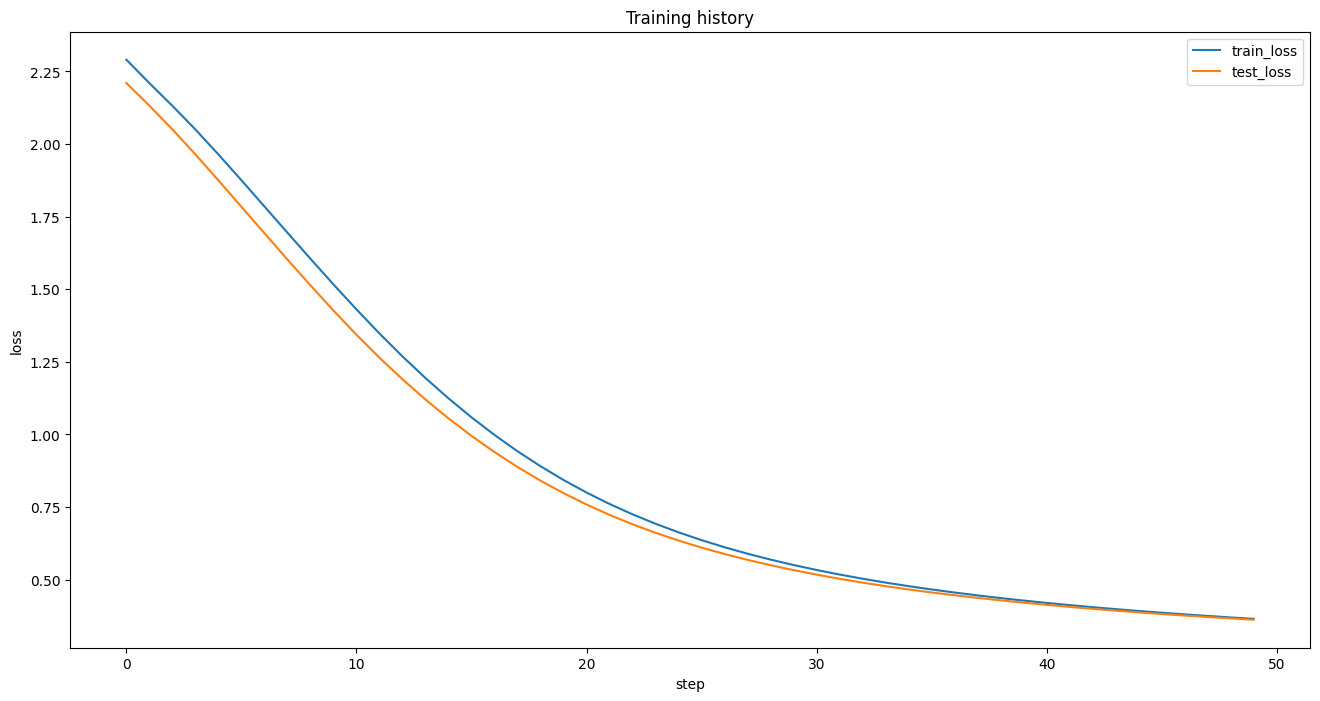

In [13]:
plt.figure(figsize=(16, 8))
plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(range(N_EPOCHS), train_loss_history, label='train_loss')
plt.plot(range(N_EPOCHS), test_loss_history, label='test_loss')
plt.legend()

In [14]:
from sklearn.metrics import classification_report

digit_probabilities = model(X_tensor_test).detach().numpy()
predictions = np.argmax(digit_probabilities, axis=1)
print(classification_report(y_tensor_test.detach().cpu().numpy(), predictions))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       823
           1       0.93      0.97      0.95       922
           2       0.91      0.90      0.90       852
           3       0.87      0.86      0.86       834
           4       0.93      0.90      0.92       797
           5       0.86      0.82      0.84       761
           6       0.92      0.95      0.93       849
           7       0.93      0.91      0.92       947
           8       0.85      0.86      0.85       789
           9       0.86      0.88      0.87       826

    accuracy                           0.90      8400
   macro avg       0.90      0.90      0.90      8400
weighted avg       0.90      0.90      0.90      8400



In [15]:
from torch.nn import ReLU

class SecondNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        super().__init__()
        
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, n_hidden_neurons)
        self.linear3 = nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.linear4 = nn.Linear(n_hidden_neurons, 10)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        
        return x

In [16]:
model = SecondNN()

# инициализация Adam для накопления импульса во время спуска
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [17]:
N_EPOCHS = 100

X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.long)
X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test, dtype=torch.long)

train_loss_history = []
test_loss_history = []

ce = nn.CrossEntropyLoss()

for i in tqdm(range(N_EPOCHS)):
    predictions = model(X_tensor_train)
    loss = ce(predictions, y_tensor_train)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    train_loss_history.append(loss.item())
    
    predictions = model(X_tensor_test)
    loss = ce(predictions, y_tensor_test)
    test_loss_history.append(loss.item())


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


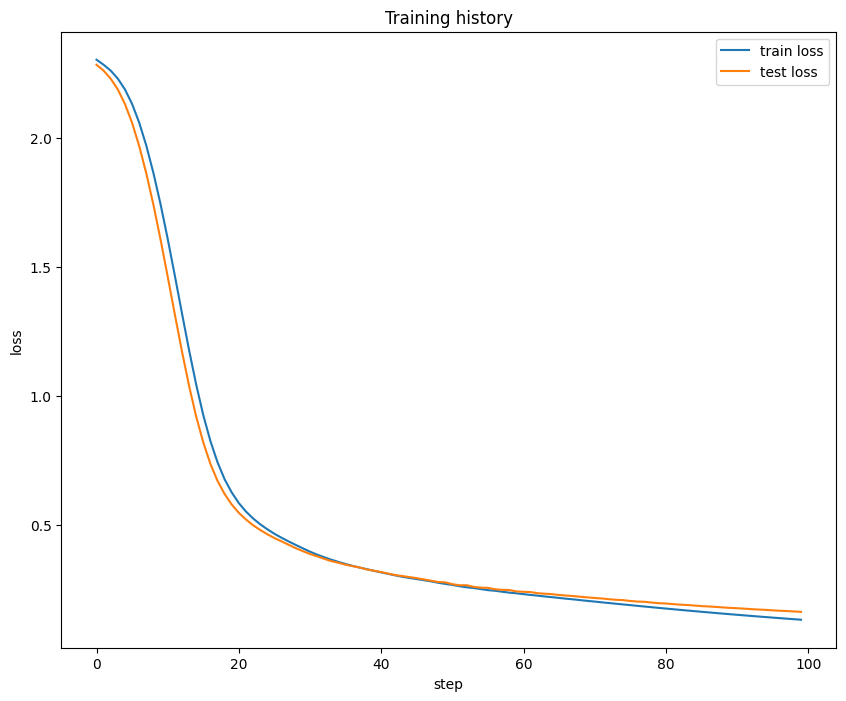

In [18]:
plt.figure(figsize=(10, 8))
plt.title("Training history")
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(range(N_EPOCHS), train_loss_history, label="train loss")
plt.plot(range(N_EPOCHS), test_loss_history, label="test loss")
plt.legend()

## Классификация изображений

In [19]:
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

transform = transforms.Compose([
    transforms.ToTensor()
])

In [20]:
train_data = datasets.CIFAR10(root="/kaggle/working/data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="/kaggle/working/data", train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 48659413.93it/s]


Extracting /kaggle/working/data/cifar-10-python.tar.gz to /kaggle/working/data
Files already downloaded and verified


In [21]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

In [22]:
dataiter = iter(train_loader)

images, labels = next(dataiter)
images.shape, labels.shape

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([16, 3, 32, 32]), torch.Size([16]))

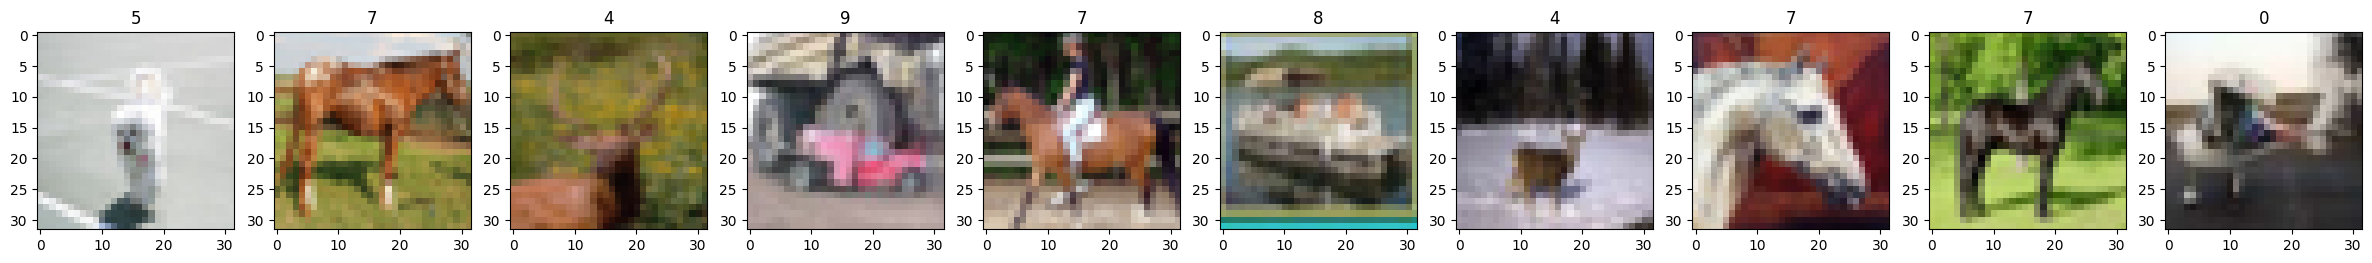

In [23]:
def show_imgs(imgs, labels):
    f, axes = plt.subplots(1, 10, figsize=(30, 5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.transpose(imgs[i].numpy(), (1, 2, 0)))
        axes[i].set_title(labels[i].numpy())

show_imgs(images, labels)

In [24]:
num_to_name = {
    0: "Самолет",
    1: "Автомобиль",
    2: "Птица",
    3: "Кошка",
    4: "Олень",
    5: "Собака",
    6: "Лягушка",
    7: "Лошадь",
    8: "Корабль",
    9: "Грузовик"
}

In [25]:
# класс для удобного первода картинок из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(32*32*3, 256) # полносвязные слои - вход и выход
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        
        # умножение на матрицу весов 2 слоя
        x = self.fc2(x)
        return x

In [26]:
from tqdm.notebook import tqdm

def train(model, n_epoch=5, lr = 1e-3):
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # алгоритм оптимизации
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_accuracy = 0
    
    for epoch in tqdm(range(n_epoch)):
        running_loss = 0.0
        train_dataiter = iter(train_loader)
        
        for i, batch in enumerate(tqdm(train_dataiter)):
            X_batch, y_batch = batch # получаем текущий батч
            optimizer.zero_grad() # обнуляем градиент
            
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0
            
        with torch.no_grad():
            accuracy = []
            for batch in test_loader:
                x, y = batch
                y_pred = model(x)

                accuracy.append(accuracy_score(y.detach().numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
            
            accuracy = np.mean(np.array(accuracy))
            if accuracy > best_accuracy:
                print(f'New best model with test acc: {accuracy}')
                torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
                best_accuracy = accuracy
        
    print('Обучение закончено')
    return model

In [27]:
model = SimpleNet()
model = train(model)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

[1,   500] loss: 2.052
[1,  1000] loss: 1.880
[1,  1500] loss: 1.841
[1,  2000] loss: 1.817
[1,  2500] loss: 1.796
[1,  3000] loss: 1.760
New best model with test acc: 0.3577


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3125 [00:00<?, ?it/s]

[2,   500] loss: 1.747
[2,  1000] loss: 1.744
[2,  1500] loss: 1.704
[2,  2000] loss: 1.713
[2,  2500] loss: 1.694
[2,  3000] loss: 1.666


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.3805


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3125 [00:00<?, ?it/s]

[3,   500] loss: 1.670
[3,  1000] loss: 1.666
[3,  1500] loss: 1.660
[3,  2000] loss: 1.655
[3,  2500] loss: 1.614
[3,  3000] loss: 1.633


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.4111


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3125 [00:00<?, ?it/s]

[4,   500] loss: 1.612
[4,  1000] loss: 1.618
[4,  1500] loss: 1.612
[4,  2000] loss: 1.624
[4,  2500] loss: 1.624
[4,  3000] loss: 1.601


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.4235


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3125 [00:00<?, ?it/s]

[5,   500] loss: 1.598
[5,  1000] loss: 1.591
[5,  1500] loss: 1.601
[5,  2000] loss: 1.598
[5,  2500] loss: 1.589
[5,  3000] loss: 1.590


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


New best model with test acc: 0.4438
Обучение закончено


In [28]:
model = SimpleNet()
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))
model.eval()

SimpleNet(
  (flatten): Flatten()
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [29]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        y_pred = model(x)
        accuracy.append(accuracy_score(y.numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))
print(f'accuracy: {accuracy}')

accuracy: 0.4438
